In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math, time
import arch 
import json
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# Data

In [6]:
#reading MarketWatch data rom a saved json
f = open('..\data\sentiments.json', encoding="utf8")
sen_data = json.load(f)
f.close()

In [53]:
price_data = pd.read_csv("..\data\\UNG.csv")

In [54]:
price_data = price_data.loc[price_data["Date"] <= "2024-04-29"].loc[price_data["Date"] >= "2015-07-14"].set_index("Date")

In [55]:
price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-14,222.240005,222.720001,216.639999,217.759995,217.759995,306288
2015-07-15,222.080002,224.800003,220.639999,223.039993,223.039993,398163
2015-07-16,222.399994,224.000000,218.399994,219.839996,219.839996,437625
2015-07-17,220.000000,221.759995,217.919998,221.759995,221.759995,222531
2015-07-20,215.520004,220.960007,215.039993,217.440002,217.440002,385106


In [58]:
price = price_data.reset_index()[["Close"]]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [59]:
price

,Close
0,0.939077
1,0.989338
2,0.958877
3,0.977154
4,0.936030
...,...
2209,-0.986863
2210,-0.997144
2211,-0.997049
2212,-1.000000


In [102]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, look_back)

In [70]:
int(np.round(0.2*price_data.shape[0]))

443

In [72]:
price_data.shape[0] - 443

1771

In [104]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# RNN

In [106]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [107]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [108]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [109]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.04417829588055611
Epoch  20 MSE:  0.006048914510756731
Epoch  30 MSE:  0.004611394368112087
Epoch  40 MSE:  0.003500363789498806
Epoch  50 MSE:  0.0026036142371594906
Epoch  60 MSE:  0.002133498899638653
Epoch  70 MSE:  0.0019377846037968993
Epoch  80 MSE:  0.0018032065127044916
Epoch  90 MSE:  0.001708858646452427


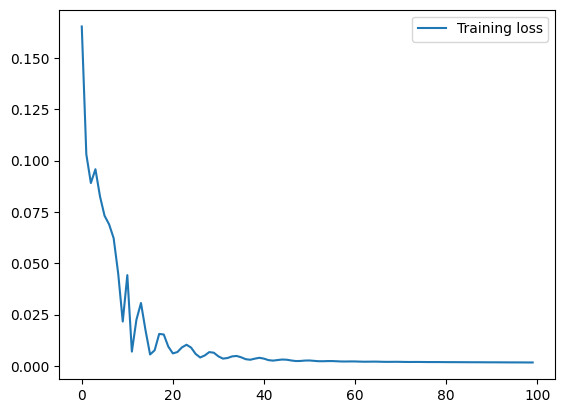

In [110]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [112]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.25 RMSE
Test Score: 4.85 RMSE


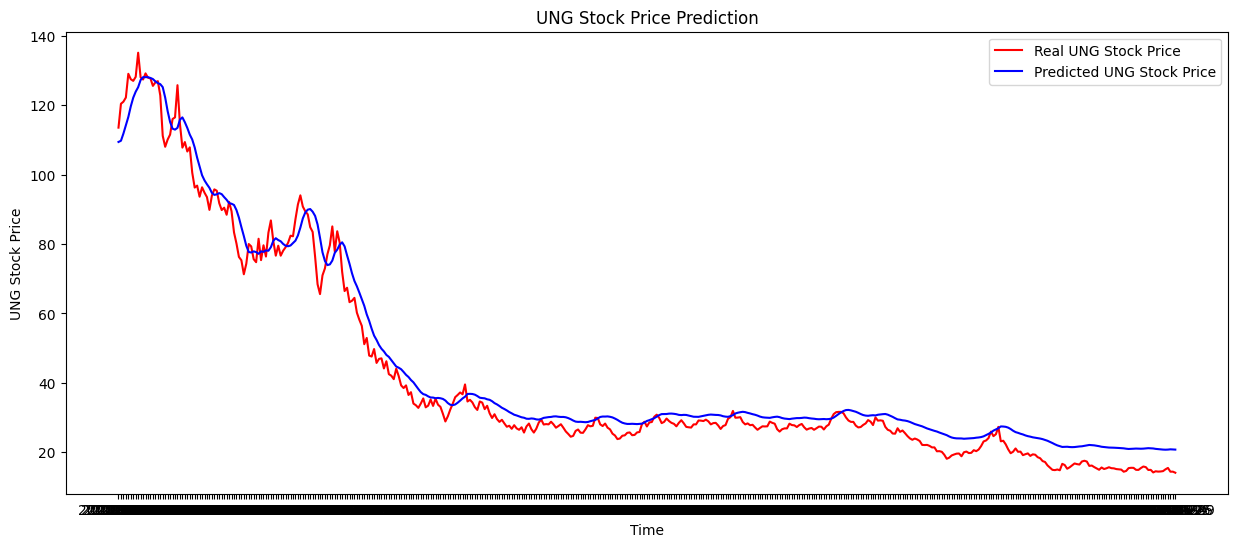

In [113]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(price_data[len(price_data)-len(y_test):].index, y_test, color = 'red', label = 'Real UNG Stock Price')
axes.plot(price_data[len(price_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted UNG Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('UNG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('UNG Stock Price')
plt.legend()
plt.savefig('ung_pred.png')
plt.show()

# Strategy

Backtesting on test data for LSTM; checking conditions on the first day of every month and selling options whih expire on 3rd Friday of that month; assume strike to be the current price

In [93]:
def third_friday(year, month):
    """Return datetime.date for monthly option expiration given year and
    month
    """
    # The 15th is the lowest third day in the month
    third = datetime.date(year, month, 15)
    # What day of the week is the 15th?
    w = third.weekday()
    # Friday is weekday 4
    if w != 4:
        # Replace just the day (of month)
        third = third.replace(day=(15 + (4 - w) % 7))
    return third

In [116]:
start = datetime.date(2022, 8, 1) #first day of first month in test period
end = datetime.date(2024, 4, 1) #first day of last month in test period
n_months = (end.year - start.year) * 12 + (end.month - start.month)
selling_dates = [start + relativedelta(months=i) for i in range(n_months+1)]
exp_dates = [third_friday(x.year, x.month) for x in selling_dates]

In [ ]:
# 5 is an offset for the few days of July that got into test data; automate in the future
x_test1 = x_test[5:]
y_test1 = y_test[5:]

In [ ]:
returns = 100 * price_data["Adj Close"].pct_change().dropna()

## Period 1

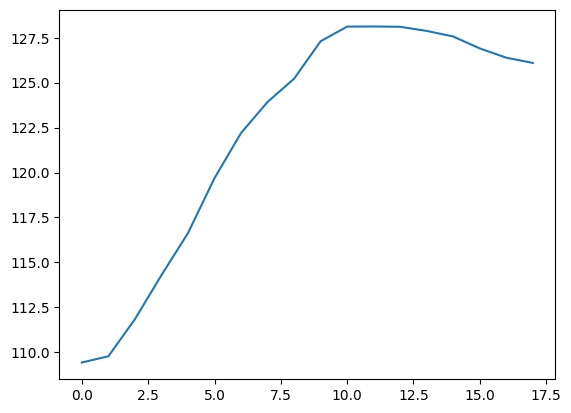

In [124]:
#------------------------predicting price with LSTM----------------------------
#need a way of automating analysis, but for now just running step by step to inspect anually
i = 0
delta1 = selling_dates[i] - start
delta2 = exp_dates[i] - start
x_cur  = x_test[delta1.days:delta2.days]
y_pred = model(x_cur)
y_pred = scaler.inverse_transform(y_pred.detach().numpy())
plt.plot(np.array(y_pred).flatten())

In [149]:
#------------------------GARCH---------------------------------
am = arch.arch_model(returns[:str(selling_dates[i])], vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)
delta3 = exp_dates[i] - selling_dates[i]
forecasts = res.forecast(horizon=delta3.days)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4258.740664316329
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4258.689258907354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4258.689258907354
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


In [155]:
print(forecasts.mean)

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414   

                h.13      h.14      h.15      h.16      h.17      h.18  
Date                                                                    
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414  


In [156]:
print(forecasts.variance)

                 h.01       h.02       h.03       h.04       h.05       h.06  \
Date                                                                           
2022-08-01  20.560726  20.610606  20.660468  20.710312  20.760138  20.809947   

                 h.07      h.08       h.09       h.10       h.11       h.12  \
Date                                                                          
2022-08-01  20.859737  20.90951  20.959266  21.009003  21.058723  21.108425   

                 h.13       h.14       h.15       h.16      h.17       h.18  
Date                                                                         
2022-08-01  21.158109  21.207776  21.257425  21.307056  21.35667  21.406266  


In [154]:
print(forecasts.residual_variance)

                 h.01       h.02       h.03       h.04       h.05       h.06  \
Date                                                                           
2022-08-01  20.560726  20.610606  20.660468  20.710312  20.760138  20.809947   

                 h.07      h.08       h.09       h.10       h.11       h.12  \
Date                                                                          
2022-08-01  20.859737  20.90951  20.959266  21.009003  21.058723  21.108425   

                 h.13       h.14       h.15       h.16      h.17       h.18  
Date                                                                         
2022-08-01  21.158109  21.207776  21.257425  21.307056  21.35667  21.406266  


In [165]:
#-------------------Sentiment Analysis------------------------
sent_df = pd.DataFrame(sen_data, columns=["Title", "Date", "Sentiment"])
sent_df["Date"] = pd.to_datetime(sent_df["Date"]).dt.date

C:\Users\atevs\AppData\Local\Temp\ipykernel_27200\2250814774.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()


<Axes: >

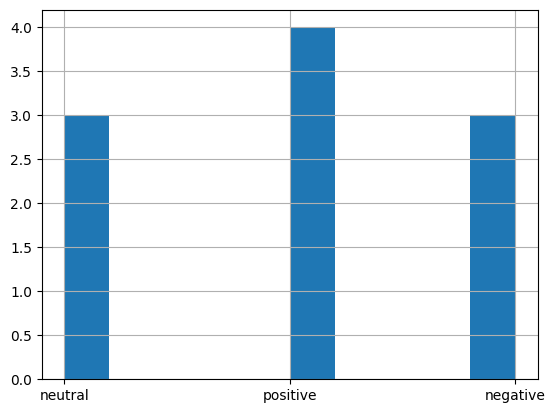

In [172]:
sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()

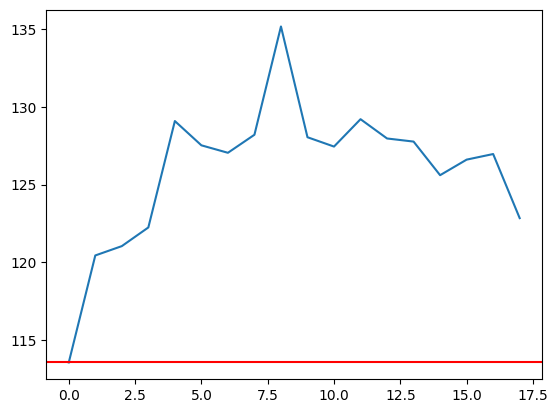

In [174]:
#-------------------Result------------------------
plt.plot(y_test[delta1.days:delta2.days])
plt.axhline(y_test[delta1.days], color='r', linestyle='-')

Accourding to our strategy, we would sell a put option with a strike equal to the current price and it would expire out-of-the-money

## Period 2

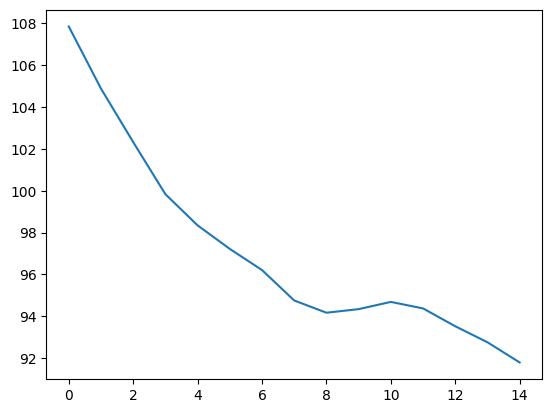

In [175]:
#------------------------predicting price with LSTM----------------------------
#need a way of automating analysis, but for now just running step by step to inspect anually
i = 1
delta1 = selling_dates[i] - start
delta2 = exp_dates[i] - start
x_cur  = x_test[delta1.days:delta2.days]
y_pred = model(x_cur)
y_pred = scaler.inverse_transform(y_pred.detach().numpy())
plt.plot(np.array(y_pred).flatten())

In [176]:
#------------------------GARCH---------------------------------
am = arch.arch_model(returns[:str(selling_dates[i])], vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)
delta3 = exp_dates[i] - selling_dates[i]
forecasts = res.forecast(horizon=delta3.days)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4321.341903856703
Iteration:     10,   Func. Count:     62,   Neg. LLF: 4321.287950755661
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4321.287950755661
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


In [177]:
print(forecasts.mean)

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2022-09-01 -0.014561 -0.014561 -0.014561 -0.014561 -0.014561 -0.014561   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2022-09-01 -0.014561 -0.014561 -0.014561 -0.014561 -0.014561 -0.014561   

                h.13      h.14      h.15  
Date                                      
2022-09-01 -0.014561 -0.014561 -0.014561  


In [178]:
print(forecasts.variance)

                 h.01      h.02       h.03       h.04       h.05       h.06  \
Date                                                                          
2022-09-01  10.127433  10.17521  10.222925  10.270578  10.318167  10.365695   

                h.07       h.08       h.09       h.10       h.11       h.12  \
Date                                                                          
2022-09-01  10.41316  10.460562  10.507903  10.555181  10.602397  10.649552   

                 h.13       h.14       h.15  
Date                                         
2022-09-01  10.696644  10.743674  10.790643  


In [179]:
print(forecasts.residual_variance)

                 h.01      h.02       h.03       h.04       h.05       h.06  \
Date                                                                          
2022-09-01  10.127433  10.17521  10.222925  10.270578  10.318167  10.365695   

                h.07       h.08       h.09       h.10       h.11       h.12  \
Date                                                                          
2022-09-01  10.41316  10.460562  10.507903  10.555181  10.602397  10.649552   

                 h.13       h.14       h.15  
Date                                         
2022-09-01  10.696644  10.743674  10.790643  


In [180]:
#-------------------Sentiment Analysis------------------------
sent_df = pd.DataFrame(sen_data, columns=["Title", "Date", "Sentiment"])
sent_df["Date"] = pd.to_datetime(sent_df["Date"]).dt.date

C:\Users\atevs\AppData\Local\Temp\ipykernel_27200\2250814774.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()


<Axes: >

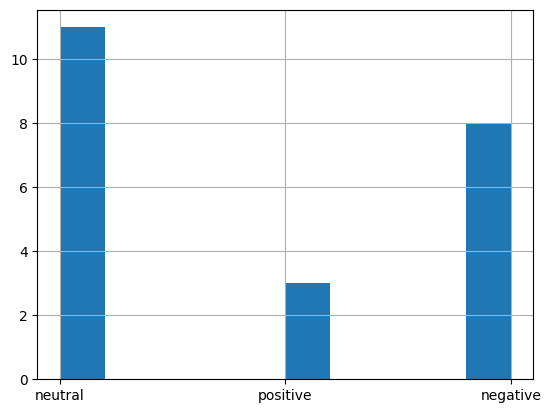

In [181]:
sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()

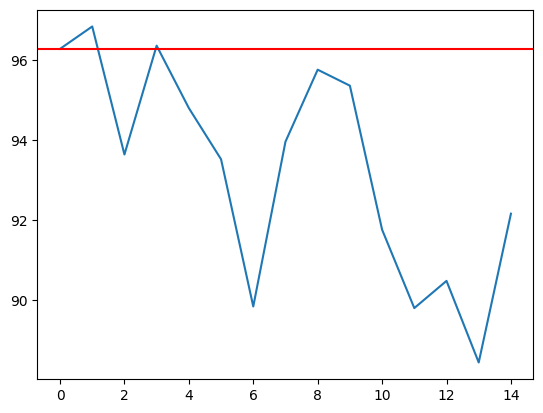

In [183]:
#-------------------Result------------------------
plt.plot(y_test[delta1.days:delta2.days])
plt.axhline(y_test[delta1.days], color='r', linestyle='-')

Accourding to our strategy, we would sell a call option with a strike equal to the current price and it would be in-of-the-money next day